In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import datetime as dt

plt.style.use('ggplot')

Vypočítáme denní počet lidí s aktivním očkováním. Posltup je následující:
- získáme denní počet uzavřených 2. dávek (1. v případě Johnosona)
- sečteme za posledních 182 dní (tj. 6 měsíců) (61 dní, 2 měsíce v případě Johnsona)
- přičteme boostery (3. dávky) mladší než 3 měsíce

In [2]:
url ='https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/ockovani-demografie.csv'
df = pd.read_csv(url)
df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
df['datum'] = df['datum'].dt.date
display(df.tail())

,id,datum,vakcina,vakcina_kod,poradi_davky,vekova_skupina,pohlavi,pocet_davek
73460,e40b22b1-a99c-4809-827a-10ffacaffa1f,2022-01-13,VAXZEVRIA,CO03,3,45-49,Z,1
73461,5828344c-4882-4b1d-b21b-aa69aaa7f5d1,2022-01-13,VAXZEVRIA,CO03,3,60-64,Z,1
73462,3d2370a5-2b7c-492d-8aa7-75b81504a548,2022-01-13,VAXZEVRIA,CO03,3,70-74,Z,2
73463,694a6936-fafe-417d-86c0-f0b7fa94d907,2022-01-13,VAXZEVRIA,CO03,3,75-79,M,3
73464,d3118734-8774-4945-96f1-76155635fb2d,2022-01-13,VAXZEVRIA,CO03,3,80+,Z,2


In [3]:
# všechno kromě Johnsona

vax01 = df[( (df['vakcina_kod']=='CO01') |
    (df['vakcina_kod']=='CO02') |
    (df['vakcina_kod']=='CO03') |
    (df['vakcina_kod']=='CO04') |            
    (df['vakcina_kod']=='CO06')) & 
    (df['poradi_davky']==2)]

vax01 = vax01.drop(['id', 'vakcina',  ### odstraneni prebytecnych sloupcu
                    'vakcina_kod', 'vekova_skupina', 
                    'poradi_davky', 'pohlavi'], axis=1) 
vax01 = vax01.groupby(['datum']).sum()  ### secteni po datumech
vax01 = vax01.rolling(min_periods=1, window=182).sum()  ### soucet poslednich 182 dni
vax01 = vax01.reset_index()
vax01.rename(columns={'datum': 'date', 
                   'pocet_davek': 'vax_active',}, inplace=True)

,date,vax_active
368,2022-01-09,2536654.0
369,2022-01-10,2474774.0
370,2022-01-11,2413215.0
371,2022-01-12,2348555.0
372,2022-01-13,2288954.0


<AxesSubplot:>

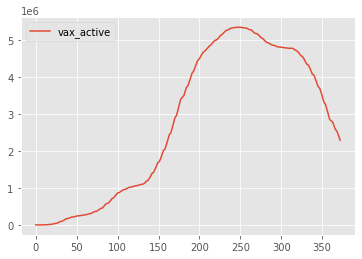

In [4]:
display(vax01.tail())
vax01.plot()

In [5]:
# Johnson
vax02 = df[(df['vakcina_kod']=='CO04')]

vax02 = vax02.drop(['id', 'vakcina',  ### odstraneni prebytecnych sloupcu
                    'vakcina_kod', 'vekova_skupina', 
                    'poradi_davky', 'pohlavi'], axis=1) 
vax02 = vax02.groupby(['datum']).sum()  ### secteni po datumech
vax02 = vax02.rolling(min_periods=1, window=61).sum()  ### soucet poslednich 61 dni
vax02 = vax02.reset_index()
vax02.rename(columns={'datum': 'date', 
                   'pocet_davek': 'vax_active',}, inplace=True)

,date,vax_active
296,2022-01-09,96142.0
297,2022-01-10,91836.0
298,2022-01-11,87370.0
299,2022-01-12,83595.0
300,2022-01-13,79469.0


<AxesSubplot:>

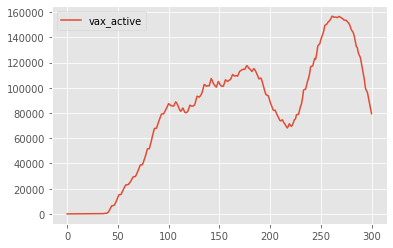

In [6]:
display(vax02.tail())
vax02.plot()

In [25]:
# Booster
boost = df[df['poradi_davky']==3]

boost = boost.drop(['id', 'vakcina',  ### odstraneni prebytecnych sloupcu
                    'vakcina_kod', 'vekova_skupina', 
                    'poradi_davky', 'pohlavi'], axis=1) 
boost = boost.groupby(['datum']).sum()  ### secteni po datumech
boost = boost.rolling(min_periods=1, window=91).sum()  ### soucet poslednich 182 dni
boost = boost.reset_index()
boost.rename(columns={'datum': 'date', 
                   'pocet_davek': 'vax_active',}, inplace=True)

,date,vax_active
0,2021-07-20,1.0
1,2021-07-30,2.0
2,2021-08-08,3.0
3,2021-08-23,4.0
4,2021-08-25,5.0
...,...,...
125,2022-01-09,2844305.0
126,2022-01-10,2910386.0
127,2022-01-11,2982243.0
128,2022-01-12,3052402.0


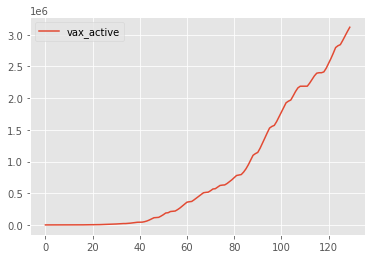

In [26]:

boost.plot()
boost

In [28]:
vaxs = pd.merge(vax01, vax02, how='outer', on='date')
vaxs = pd.merge(vaxs, boost, how='outer', on='date')
vaxs = vaxs.fillna(0)
vaxs

,date,vax_active_x,vax_active_y,vax_active
0,2020-12-29,1.0,0.0,0.0
1,2021-01-05,3.0,0.0,0.0
2,2021-01-06,4.0,0.0,0.0
3,2021-01-08,5.0,0.0,0.0
4,2021-01-09,6.0,0.0,0.0
...,...,...,...,...
368,2022-01-09,2536654.0,96142.0,2844305.0
369,2022-01-10,2474774.0,91836.0,2910386.0
370,2022-01-11,2413215.0,87370.0,2982243.0
371,2022-01-12,2348555.0,83595.0,3052402.0


In [29]:
vaxs['vaxs_active'] = vaxs['vax_active_x'] + vaxs['vax_active_y'] + vaxs['vax_active']
vaxs = vaxs.drop(['vax_active_x', 'vax_active_y', 'vax_active', ], axis=1) 

In [30]:
display(vaxs.tail())

,date,vaxs_active
368,2022-01-09,5477101.0
369,2022-01-10,5476996.0
370,2022-01-11,5482828.0
371,2022-01-12,5484552.0
372,2022-01-13,5487379.0


<AxesSubplot:>

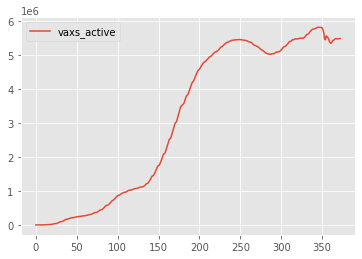

In [31]:
vaxs.plot()

<AxesSubplot:>

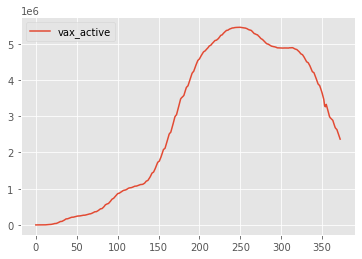

In [22]:
vaxs.plot()

In [32]:
vaxs

,date,vaxs_active
0,2020-12-29,1.0
1,2021-01-05,3.0
2,2021-01-06,4.0
3,2021-01-08,5.0
4,2021-01-09,6.0
...,...,...
368,2022-01-09,5477101.0
369,2022-01-10,5476996.0
370,2022-01-11,5482828.0
371,2022-01-12,5484552.0
